In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/중요 Backup (icloud etc)/학교/4학년 2학기/종설/"
filename = path + "stats.csv"
train_df = pd.read_csv(filename)

other_df = train_df.copy()
columns_exclude = ["year", "round_num", "tmp_team_name", "opponent", "win"]
other_df2 = other_df.drop(columns=columns_exclude)
other_df2.columns = [f"{col}_opponent" for col in other_df2.columns]
other_df2.loc[:, :] = -1

df = pd.concat([train_df, other_df2], axis=1)

print(len(df))

2076


In [ ]:
print(df.iloc[0]['goals'], df.iloc[0]['goals_opponent'])
stat_features = ['goals', 'assists', 'total_shootings', 'shots_on_target', 'shots_blocked', 'shots_out_of_bounds', 'shots_in_PA', 'shots_out_PA', 'offsides', 'freekicks_on_target', 'freekicks_on_cross', 'cornerkicks', 'throwins', 'dribbles', 'tot_passes', 'passes_critical', 'passes_in_defense_area', 'passes_long_range', 'passes_short_range', 'passes_forward', 'passes_middle_range', 'passes_horizontal', 'passes_backward', 'passes_crosses', 'passes_in_attack_area', 'passes_in_middle_area', 'dismarks', 'tackles', 'fights_air', 'fights_ground', 'ball_intercepts', 'ball_clearings', 'ball_cuts', 'ball_gains', 'ball_blocks', 'ball_misses', 'fouls_against_other_team', 'fouls_against_own_team', 'yellow_cards', 'red_cards', 'goals_conceded', 'goalkeeper_catchings', 'goalkeeper_punchings', 'goalkeeper_goalkicks', 'goalkeeper_air_clearings']

print('original len(df) : ', len(df))

to_drop = []
for i, this_team in df.iterrows():
  if i in to_drop:
    continue
  opponent = df[(df['year'] == this_team.year) & (df['round_num'] == this_team.round_num) & (df['tmp_team_name'] == this_team.opponent) & (df['opponent'] == this_team.tmp_team_name)]

  if not opponent.empty:
    for feature in stat_features:
      df.at[i, feature + '_opponent'] = opponent[feature].values[0]
    to_drop.extend(opponent.index.tolist())

df.drop(index=to_drop, inplace=True)

df = df[df.goals_opponent != -1]

print('total rows: ', len(df))
print(df.iloc[0])

0 -1
original len(df) :  2076
total rows:  1038
year                                 2020
round_num                               1
tmp_team_name                          인천
opponent                               대구
goals                                   0
                                     ... 
goals_conceded_opponent                 0
goalkeeper_catchings_opponent           1
goalkeeper_punchings_opponent           0
goalkeeper_goalkicks_opponent           8
goalkeeper_air_clearings_opponent       0
Name: 0, Length: 95, dtype: object


In [ ]:
labels = df['win']
print(labels)
exclude_columns = ['win', 'year', 'round_num', 'tmp_team_name', 'opponent', 'dismarks', 'goals', 'goals_opponent', 'goals_conceded', 'goals_conceded_opponent']

df = df.drop(columns=exclude_columns)
data = df.dropna(axis=1, how='any')

print(df.columns)
print(len(labels))
print(len(data))

data_tmp = pd.concat([data, labels], axis=1)
#data_tmp.to_csv(path + 'ouput1.csv', index=False, header=True)

0       draw
1        win
2        win
3        win
4       draw
        ... 
2022     win
2025    draw
2027    draw
2035     win
2041    draw
Name: win, Length: 1038, dtype: object
Index(['assists', 'total_shootings', 'shots_on_target', 'shots_blocked',
       'shots_out_of_bounds', 'shots_in_PA', 'shots_out_PA', 'offsides',
       'freekicks_on_target', 'freekicks_on_cross', 'cornerkicks', 'throwins',
       'dribbles', 'tot_passes', 'passes_critical', 'passes_in_defense_area',
       'passes_long_range', 'passes_short_range', 'passes_forward',
       'passes_middle_range', 'passes_horizontal', 'passes_backward',
       'passes_crosses', 'passes_in_attack_area', 'passes_in_middle_area',
       'tackles', 'fights_air', 'fights_ground', 'ball_intercepts',
       'ball_clearings', 'ball_cuts', 'ball_gains', 'ball_blocks',
       'ball_misses', 'fouls_against_other_team', 'fouls_against_own_team',
       'yellow_cards', 'red_cards', 'goalkeeper_catchings',
       'goalkeeper_punchings', 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
label_encoder = LabelEncoder()

print(labels)
labels = label_encoder.fit_transform(labels)
#df['tmp_team_name'] = label_encoder.fit_transform(df['tmp_team_name'])
#df['opponent'] = label_encoder.fit_transform(df['opponent'])

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(labels)
class_names = label_encoder.classes_
print(class_names)
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label to Number Mapping:", mapping)
#class_names = np.array(['win', 'draw', 'lose'])
feature_names = data.columns.tolist()

0       draw
1        win
2        win
3        win
4       draw
        ... 
2022     win
2025    draw
2027    draw
2035     win
2041    draw
Name: win, Length: 1038, dtype: object
[0 2 2 ... 0 2 0]
['draw' 'lose' 'win']
Label to Number Mapping: {'draw': 0, 'lose': 1, 'win': 2}


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [ ]:
y_proba = model.predict_proba(X_test)

threshold = 0.7
y_pred_custom = (y_proba[:, 1] >= threshold).astype(int)

# 성능 평가
accuracy = accuracy_score(y_test, y_pred_custom)

print(f"Custom Threshold (0.7) Accuracy: {accuracy}")

Custom Threshold (0.7) Accuracy: 0.4519230769230769


In [ ]:
import joblib

joblib.dump(model, path+'stats_model.pkl')

['/content/drive/MyDrive/중요 Backup (icloud etc)/학교/4학년 2학기/종설/stats_model.pkl']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

# 모델 훈련
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nMean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 0.5358853010641339
R^2 Score: 0.1936372542696616


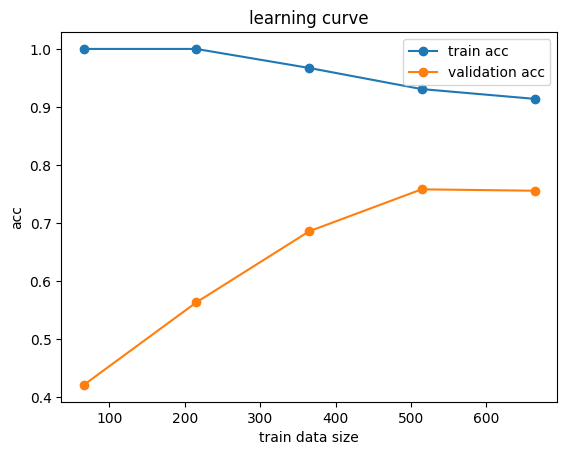

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="train acc")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="validation acc")
plt.xlabel("train data size")
plt.ylabel("acc")
plt.legend()
plt.title("learning curve")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

# 모델 훈련
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n정확도:", accuracy)
print("\n분류 리포트:\n", report)


정확도: 0.625

분류 리포트:
               precision    recall  f1-score   support

           0       0.43      0.16      0.23        57
           1       0.70      0.77      0.73        66
           2       0.61      0.82      0.70        85

    accuracy                           0.62       208
   macro avg       0.58      0.58      0.56       208
weighted avg       0.59      0.62      0.58       208



<ipython-input-150-3d517f87b179>:11: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  plt.savefig(path+"decision_tree.png", bbox_inches='tight', dpi=300)
<ipython-input-150-3d517f87b179>:11: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.savefig(path+"decision_tree.png", bbox_inches='tight', dpi=300)
<ipython-input-150-3d517f87b179>:11: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  plt.savefig(path+"decision_tree.png", bbox_inches='tight', dpi=300)
<ipython-input-150-3d517f87b179>:11: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  plt.savefig(path+"decision_tree.png", bbox_inches='tight', dpi=300)
<ipython-input-150-3d517f87b179>:11: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.savefig(path+"decision_tree.png", bbox_inches='tight', dpi=300)
<ipython-input-150-3d517f87b179>:11: UserWarning: Glyph 44033 (\N{HANGUL 

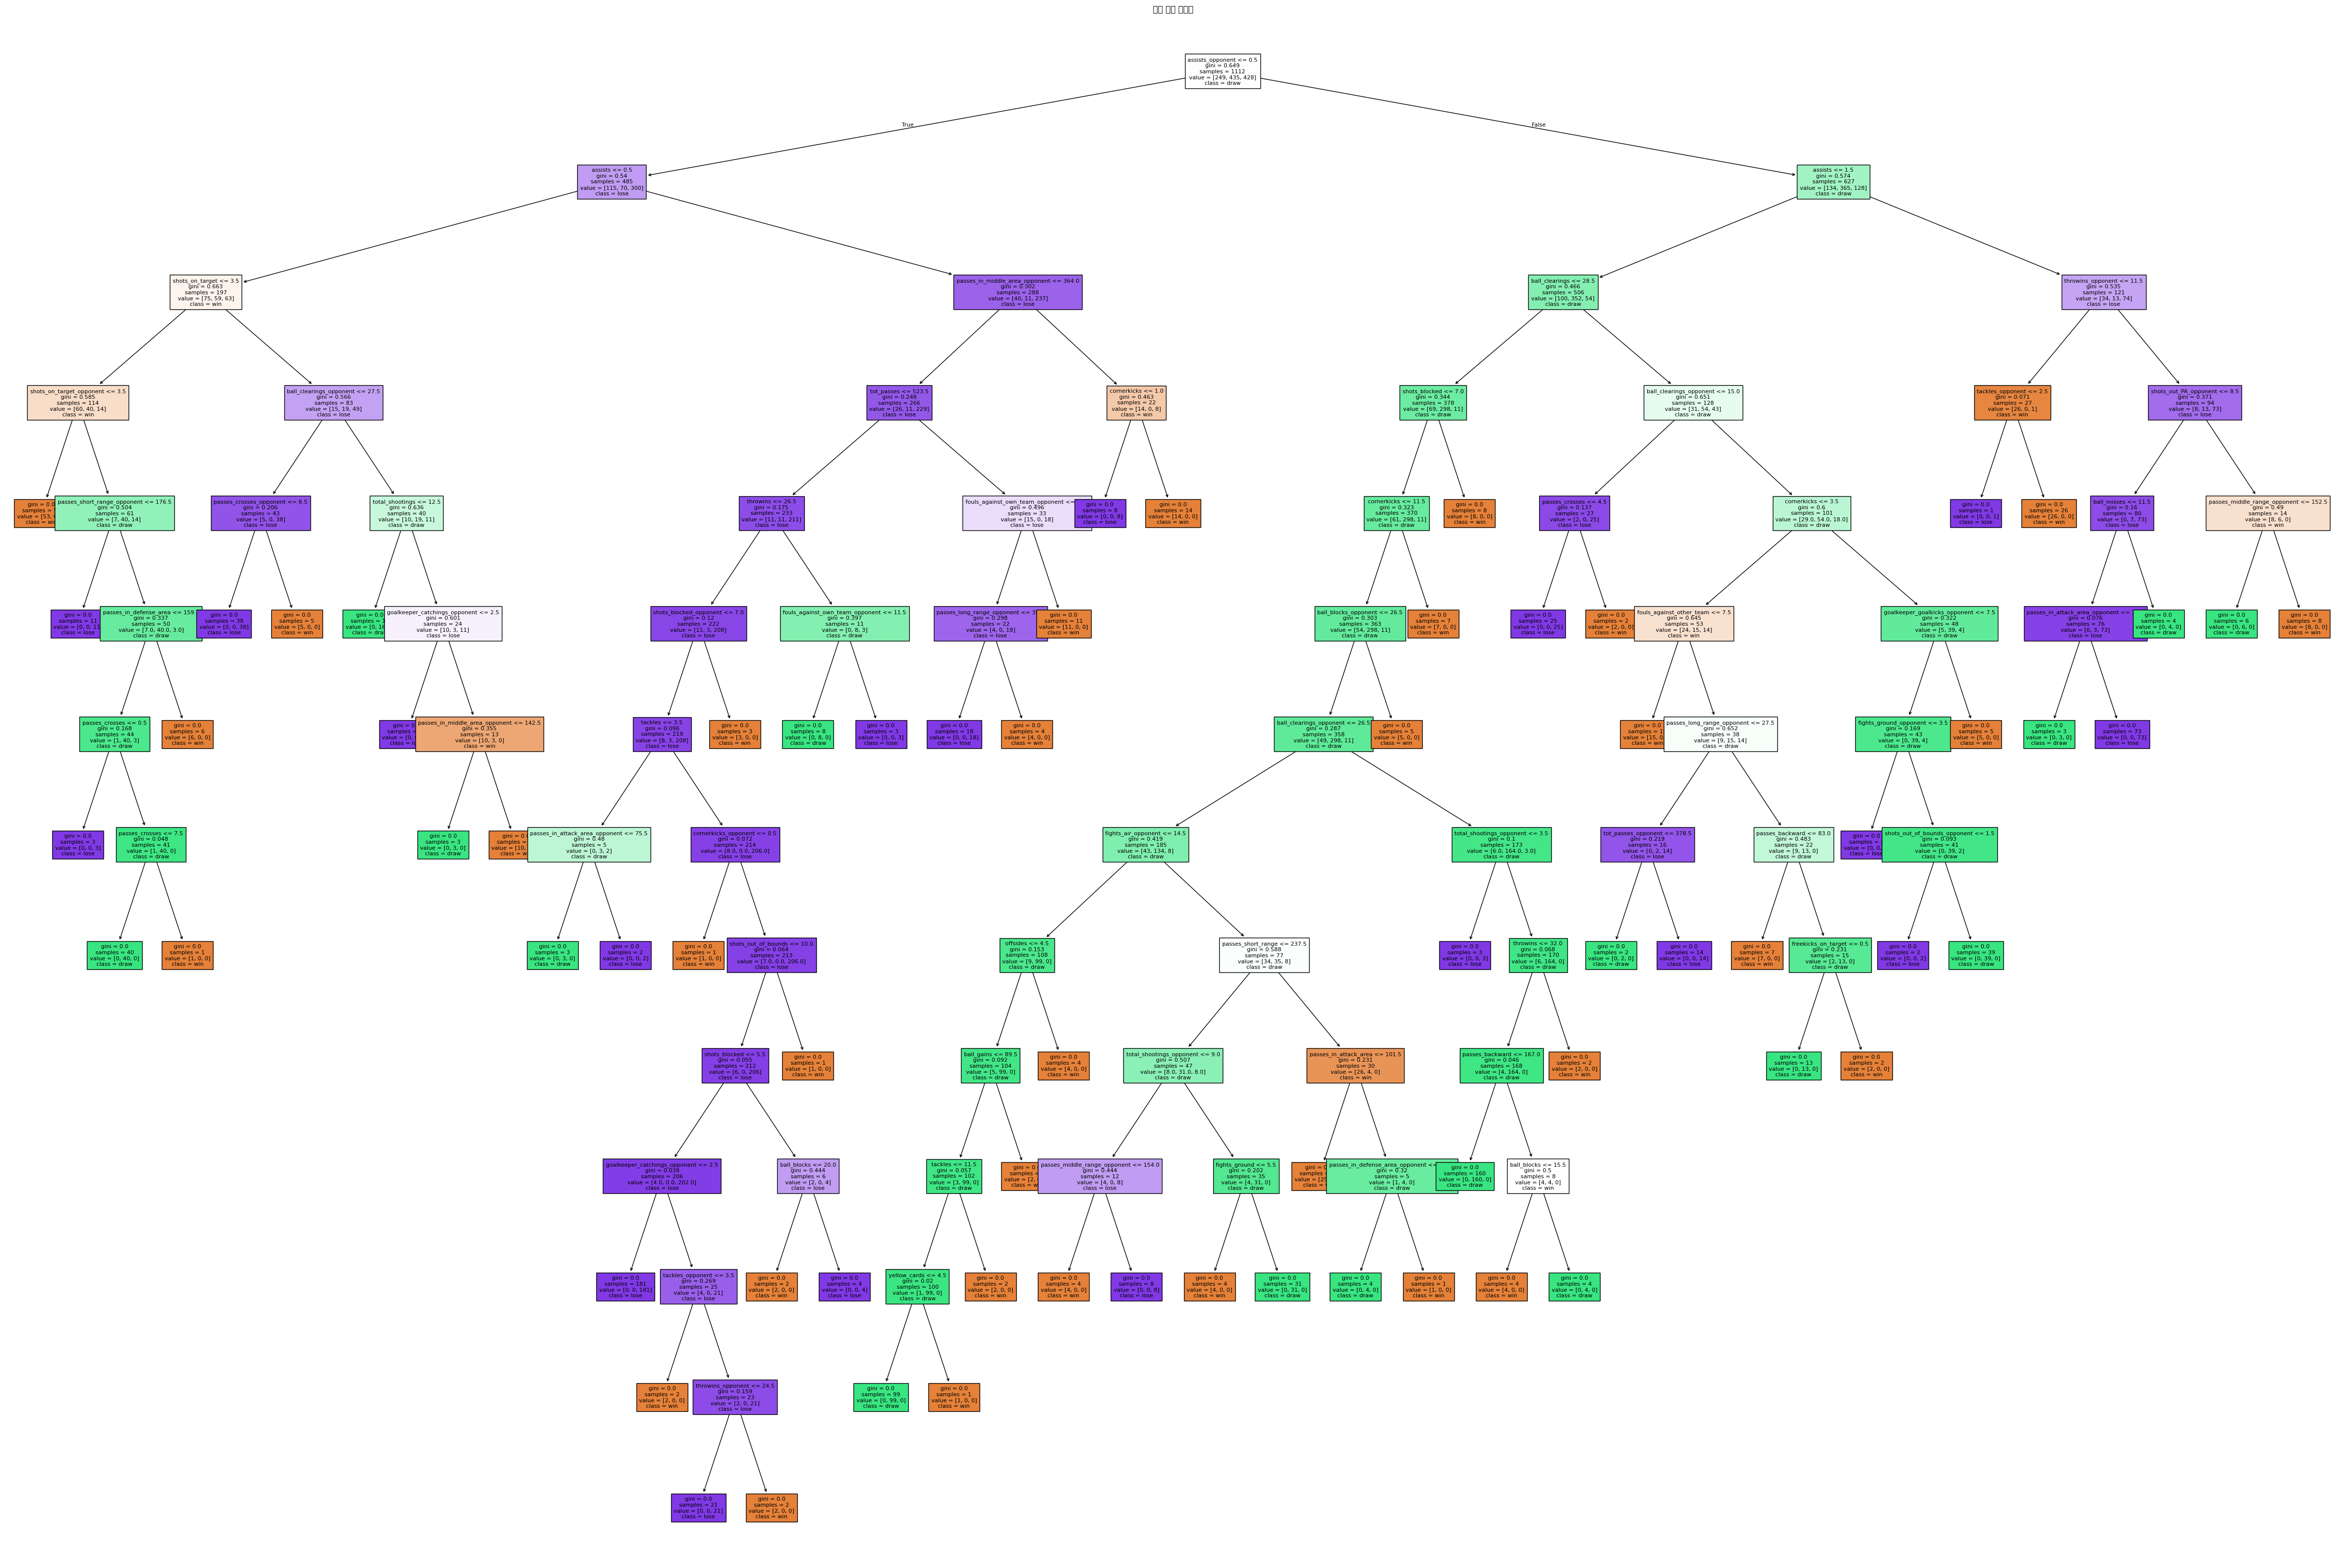

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np

plt.figure(figsize=(60,40))
plot_tree(model,
          feature_names=feature_names,
          class_names=class_names,
          filled=True, fontsize=8)
plt.title("결정 트리 시각화")
plt.savefig(path+"decision_tree.png", bbox_inches='tight', dpi=300)
plt.show()